In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Kernel:
    def __init__(self, sig_var, length_scale):
        self.sig_var = sig_var
        self.length_scale = length_scale
    def __call__(self, x1, x2):
        ## Define covariance function
        return self.sig_var**2 * np.exp(-((x1-x2)**2)/2*self.length_scale**2)
    def param_adjust(self, sig_var, length_scale):
        self.sig_var = sig_var
        self.length_scale = length_scale

In [3]:
def calc_cov(x1, x2,kernel):
    return np.array([[kernel(i, j) for i in x1] for j in x2])

In [4]:
class GaussianProcessRegression:
    def __init__(self, X, y, kernel = Kernel(2, 2), noise = 2):
        self.X = X
        self.y = y
        self.kernel = kernel
        self.noise = noise
        ##inverse covariance matrix of training data on itself
        self.inv_input_cov = np.linalg.inv(calc_cov(X, X, kernel) + (noise) * np.identity(len(X)))
    
    def predict(self, to_predict):
        val1 = calc_cov(self.X, to_predict, self.kernel) #X-train and X-test covariance
        val2 = calc_cov(to_predict, to_predict, self.kernel) #X-test covariance on itself
        
        mean_to_predict = (val1 @ (self.y @ self.inv_input_cov.T).T).flatten()
        
        cov_to_predict = val2 - val1 @ self.inv_input_cov @ val1.T 
        
        var = np.diag(cov_to_predict)
        
        return [mean_to_predict, cov_to_predict]
        

In [44]:
from scipy.linalg import solve_triangular
from scipy.optimize import minimize
from scipy import optimize
def neg_likelihood(xtrain, ytrain, kernel):
    ytrain = ytrain.ravel()
    def nll(theta):
        kernel.param_adjust(theta[0], theta[1])
        cov = calc_cov(xtrain, xtrain, kernel) + theta[2]**2 * np.eye(len(xtrain))
        #L = np.linalg.cholesky(cov)
        #S1 = solve_triangular(L, ytrain, lower = True)
        #S2 = solve_triangular(L.T, S1, lower = False)
        return 0.5 * np.log(np.linalg.det(cov)) + 0.5 * ytrain @ np.linalg.inv(cov) @ ytrain + 0.5 * len(xtrain) * np.log(2*np.pi)
        #return np.sum(np.log(np.diagonal(L))) + 0.5 * ytrain@S2 + 0.5 * len(xtrain) * np.log(2*np.pi)
    return nll

In [74]:
x_vals = sorted(np.random.uniform(low=-9, high=9, size=30))
#x_vals = [i**2 + i for i in x_vals]
y_vals = np.sin(x_vals) + np.random.normal(0, 0.7**2, len(x_vals))

In [75]:
#optimal_sig_var, optimal_lenscale = \
#optimize.fmin_bfgs(neg_likelihood(x_vals, y_vals, 2, Kernel(10, 10)), [10, 10])
optimal_sig_var, optimal_lenscale, noise = \
minimize(neg_likelihood(x_vals, y_vals, Kernel(1, 1)), [1, 1, 1], bounds = ((0, None), (0, None), (0.0001, None))).x

In [76]:
optimal_sig_var, optimal_lenscale, noise

(0.9007882099028365, 0.8045885265477879, 0.46023509472085117)

### Viz

In [77]:
#x_vals = sorted(np.random.uniform(low=-9, high=9, size=30))
#y_vals = np.sin(x_vals)
x = np.linspace(start = -10, stop = 10, num = 100)

In [78]:
model = GaussianProcessRegression(x_vals, y_vals, Kernel(optimal_sig_var, optimal_lenscale), noise = noise)
mu, sigma = model.predict(x)

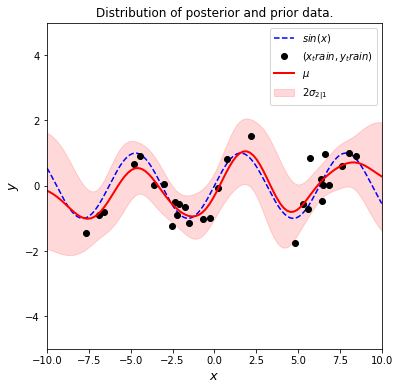

In [79]:
fig, ax1 = plt.subplots(
    nrows = 1, ncols=1, figsize=(6, 6))

# Plot the correct distribution
x_space = np.linspace(start=-10, stop=10, num=1000)
y_space = np.sin(x_space)
ax1.plot(x_space, y_space, 'b--', label='$sin(x)$')
ax1.plot(x_vals, y_vals, 'ko', linewidth=2, label='$(x_train, y_train)$')

# Plot the posterior
ax1.plot(x, mu, 'r-', lw=2, label='$\mu$')
ax1.fill_between(x, mu-2*np.sqrt(np.diag(sigma)), mu+2*np.sqrt(np.diag(sigma)), color='red', alpha=0.15, label='$2 \sigma_{2|1}$')


ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([-10, 10, -5, 5])
ax1.legend()

### Sample from N(0, k) --> Sample from standard multivariate normal (0, I) and apply transformation of multiplying by (k)^1/2 --> results in N(0, k)